In [1]:
# import sys
# print (sys.version)

# Import libraries for Finance (Yahoo Finance) and Technical Analysis
import yfinance as yf
import talib

# Import libraries for data handling and visualization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#Import internal functions to load data, etc
#import initialize

#Setting up constants
QUICK_EMA_PERIOD = 14
SLOW_EMA_PERIOD = 26

In [2]:
def init(fromCSV = False, numberOfStocks = 10, daysSince=14, typeDate='Close'):

    if (fromCSV == True):
        print ("Returning stored data.")
        return ((pd.read_csv('rawdata.csv')).set_index('Date'))

    print(f"Requested days: {daysSince}.\nRequested stocks: {numberOfStocks}.\nData type: {typeDate}.")

    tickers_df = pd.read_csv('sp500_tickers.csv').head(numberOfStocks)
    tickers_df.set_index('Ticker', inplace=True)
    tickers_df.sort_values(by='Ticker', inplace=True)

    tickers_string = ' '.join(tickers_df.index.values)
    ts_today = pd.to_datetime('today')
    ts_origin = ts_today - pd.Timedelta(days=daysSince)


    return (yf.download(tickers_string, start=ts_origin, end=ts_today)[typeDate])

    
rawdata = init(fromCSV=True, numberOfStocks=5000, daysSince=90)
rawdata.to_csv('./rawdata.csv')

companies = rawdata.columns.values

def real2double(real_data):
    return(np.array(real_data,dtype='f8'))
    

Returning stored data.


In [3]:
def get_EMA_df(qema_period, sema_period):
    '''Builds a multiindex dataframe composed of two sub-dfs: quick and slow EMA'''
    df_dict = dict((label, pd.DataFrame()) for label in ['Quick', 'Slow', 'Ratio'])

    for x in rawdata.columns:
        df_dict['Quick'][x] = talib.EMA(real2double(rawdata[x].values), timeperiod=qema_period)
        df_dict['Slow'][x] = talib.EMA(real2double(rawdata[x].values), timeperiod=sema_period)
        df_dict['Ratio'][x] = 100*(df_dict['Quick'][x] - df_dict['Slow'][x])/df_dict['Quick'][x]

    return(pd.concat([df_dict['Quick'], df_dict['Slow'], df_dict['Ratio']], axis=1, keys=['Quick', 'Slow', 'Ratio']))

EMA_df = get_EMA_df(QUICK_EMA_PERIOD, SLOW_EMA_PERIOD)

/var/folders/5_/77bq8h093_sd9djb8xy8w02h0000gn/T/ipykernel_961/1651614482.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_dict['Quick'][x] = talib.EMA(real2double(rawdata[x].values), timeperiod=qema_period)
/var/folders/5_/77bq8h093_sd9djb8xy8w02h0000gn/T/ipykernel_961/1651614482.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_dict['Slow'][x] = talib.EMA(real2double(rawdata[x].values), timeperiod=sema_period)
/var/folders/5_/77bq8h093_sd9djb8xy8w02h0000gn/T/ipykernel_961/1651614482.py:8: PerformanceWarning: DataFra

In [4]:
def get_intersection_point(EMA_df, rawdata):
    '''Returns a df containing:
    Index from where the qEMA started leading the sEMA.
    Value at that time
    Value now
    Average growth since turning point
    '''
    item_positive_bool = (EMA_df['Quick'] - EMA_df['Slow'])>0
    idx_intersection_dict = dict()
    value_intersection_dict = dict()
    value_now_dict = dict()
    growth_dict = dict()

    for company in item_positive_bool.columns:

        #Get the index when qEMA started bullysh trend
        company_positive_bool =(list(item_positive_bool[company]))
        company_positive_bool.reverse()
        turning_change_index = company_positive_bool.index(False)
        idx_intersection_dict[company] = turning_change_index

        #Get both values by the intersection and current, and associated growth
        value_intersection_dict[company] = round(rawdata[company].iloc[-(turning_change_index+1)],2)
        value_now_dict[company] = round(rawdata[company].iloc[-1],2)
        growth_dict[company] = round(100*(value_now_dict[company] - value_intersection_dict[company])/value_intersection_dict[company],2)

    intersection_points_df = pd.DataFrame([idx_intersection_dict, value_intersection_dict, value_now_dict, growth_dict],
        index = ["Turning point", "Turning value", "Value now", "Percent Growth"]).transpose()#.sort_values(by="Percent Growth", ascending=False)
    
    
    return (intersection_points_df)

keyStats = get_intersection_point(EMA_df, rawdata)

In [5]:
def ratioWrapper(EMA_df, companies, keyStats):
    '''Return two more columns 
    - Average ratio of qEMA / sEMA since qEMA started leading (bullysh trend)
    - Minimum value of that ratio since that moment PLUS two periods (to allow the qEMA to gain momentum)

    The goal is to put first those companies with a stronger qEMA leadership.
    '''
    avgRatio_list = []
    minAbs_list = []

    for company in companies:
        
        getFrom = int(keyStats['Turning point'].loc[company])
        avgRatio = round(EMA_df['Ratio'][company][-getFrom:].mean(),2) * (getFrom > 0 ) 
        avgRatio_list.append(avgRatio)

        MinAbsRatio = round(EMA_df['Ratio'][company][-getFrom+2:].min(),2) * (getFrom > 0 ) 
        minAbs_list.append(MinAbsRatio)

    return (avgRatio_list, minAbs_list)

(keyStats['avgRatio'], keyStats['MinAbsRatio']) = ratioWrapper(EMA_df, companies, keyStats)


In [6]:
def filter_companies(keyStats, aboveAvgRatio=False, aboveMinAbs=False, minPositivePeriod = False):
    keyStats.sort_values(by='avgRatio', ascending=False, inplace=True)
    if(aboveAvgRatio):
        keyStats = keyStats[keyStats['avgRatio'] >= aboveAvgRatio]
    if(aboveMinAbs):
        keyStats = keyStats[keyStats['MinAbsRatio'] >= aboveMinAbs]
    if(minPositivePeriod):
        keyStats = keyStats[keyStats['Turning point'] >= minPositivePeriod]
    return (keyStats.index.values)

filteredCompanies = filter_companies(keyStats, aboveAvgRatio=0.1, aboveMinAbs=0.1, minPositivePeriod=10)

In [7]:
def reset_filtered_companies():
    global filteredCompanies
    filteredCompanies = companies


In [8]:
EMA_df['Slow'].shape


(62, 501)

In [9]:
def plot_all(filteredCompanies, limit=10):
    print (f"Displaying {limit} first companies")
    x_axis = rawdata.index

    for x in (filteredCompanies[0:limit]):
        print(f"Company {x}, with {keyStats.loc[x][0]} periods")
        plt.plot(x_axis, EMA_df['Quick'][x], 'r')
        plt.plot(x_axis, EMA_df['Slow'][x], 'b')
        plt.plot(x_axis, rawdata[x], 'g')
        plt.show()

Displaying 10 first companies
Company META, with 37.0 periods


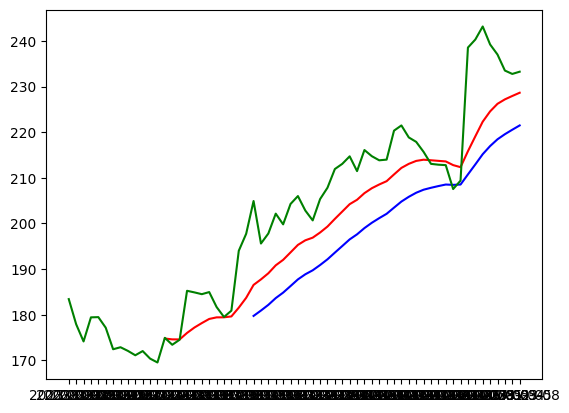

Company NVDA, with 37.0 periods


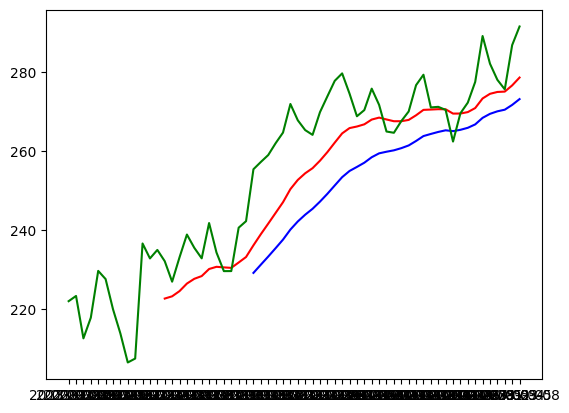

Company WST, with 37.0 periods


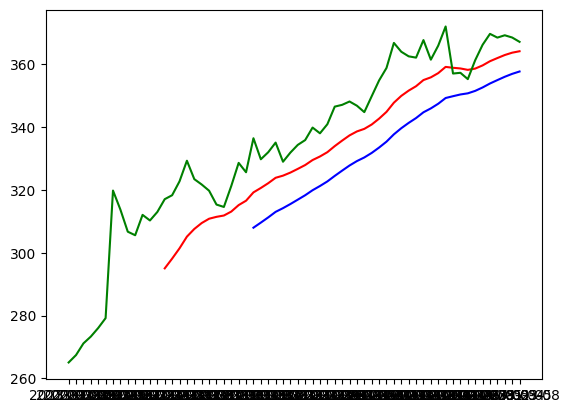

Company ISRG, with 33.0 periods


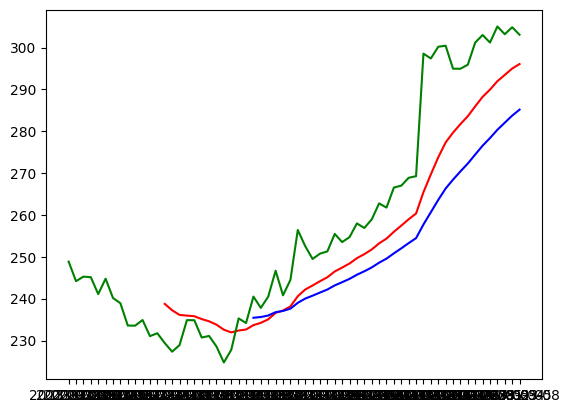

Company MKC, with 29.0 periods


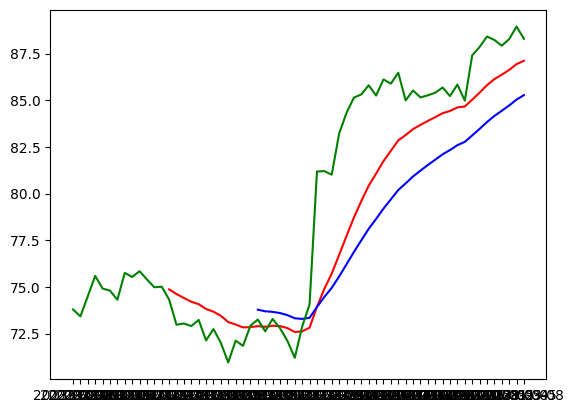

Company GE, with 37.0 periods


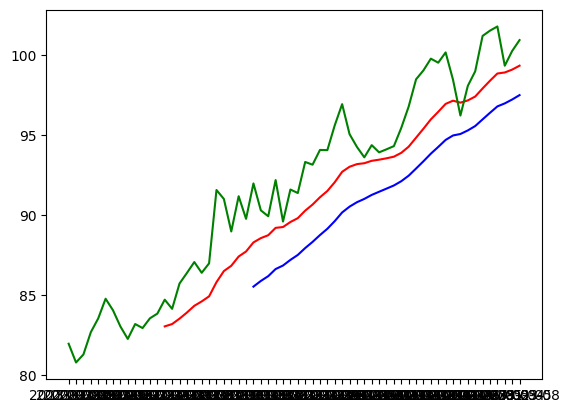

Company CRM, with 37.0 periods


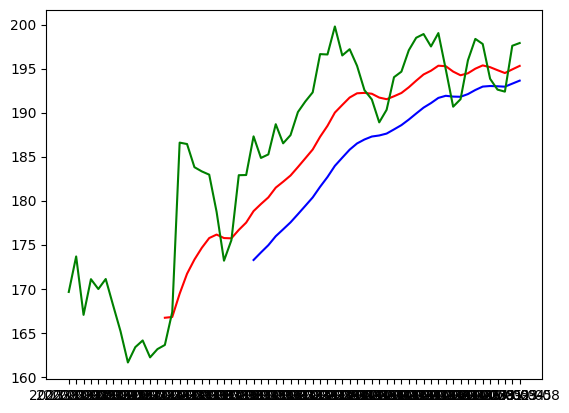

Company TAP, with 21.0 periods


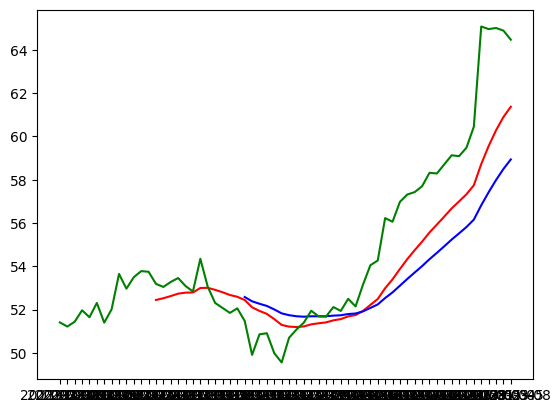

Company INTC, with 37.0 periods


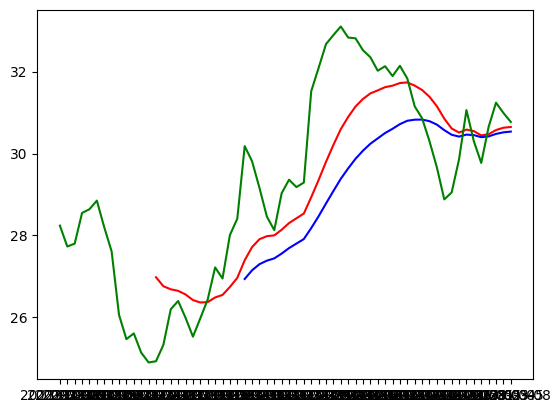

Company LLY, with 31.0 periods


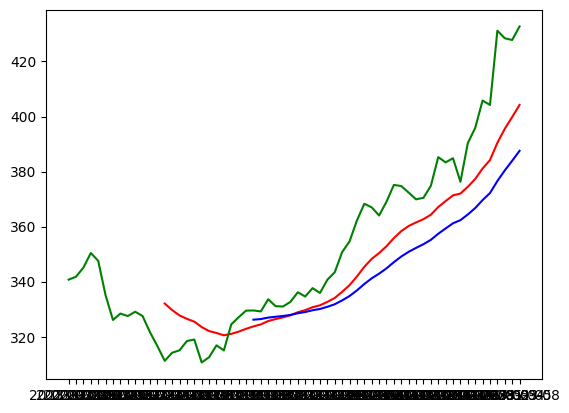

In [10]:
plot_all(filteredCompanies)#, limit=3)